In [1]:
# Datasets: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset

# Machine Learning: https://www.kaggle.com/code/mejbahahammad/movie-recommender-systems-using-neural-network

import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime

from datetime import datetime
now = datetime.now()

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
%matplotlib inline

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import lightgbm as lgb

import tensorflow as tf
import keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras.layers import Embedding, Flatten, dot
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.optimizers import Adam
plt.style.use("fivethirtyeight")

In [2]:
books_df = pd.read_csv("./datasets/Books.csv")
ratings_df = pd.read_csv("./datasets/Ratings.csv")
users_df = pd.read_csv("./datasets/Users.csv")

C:\Users\andre\AppData\Local\Temp\ipykernel_25540\1667501559.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv("./datasets/Books.csv")


In [3]:
books_df.info(), ratings_df.info(), users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), obje

(None, None, None)

In [4]:
books_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [5]:
ratings_df

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [6]:
users_df

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


In [7]:
books_df.drop(columns=["Image-URL-S", "Image-URL-M", "Image-URL-L"], axis=1, inplace=True)
books_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press


In [8]:
ratings_df

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [9]:
df = pd.merge(books_df, ratings_df, on="ISBN")
df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,41385,0
...,...,...,...,...,...,...,...
1031131,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),276463,7
1031132,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,276579,4
1031133,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,276680,0
1031134,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,276680,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031136 entries, 0 to 1031135
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1031136 non-null  object
 1   Book-Title           1031136 non-null  object
 2   Book-Author          1031135 non-null  object
 3   Year-Of-Publication  1031136 non-null  object
 4   Publisher            1031134 non-null  object
 5   User-ID              1031136 non-null  int64 
 6   Book-Rating          1031136 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 62.9+ MB


In [11]:
df["Year-Of-Publication"] = df["Year-Of-Publication"].astype(str)
df["Year-Of-Publication"] = df["Year-Of-Publication"].map(lambda entry: entry if entry.isnumeric() else df["Year-Of-Publication"].mode()[0])
df["Year-Of-Publication"] = df["Year-Of-Publication"].astype("int64")

df["Book-Author"].fillna("N/A", inplace=True)
df["Publisher"].fillna("N/A", inplace=True)

df["Book-Title"] = df["Book-Title"].astype(str)
df["Book-Author"] = df["Book-Author"].astype(str)
df["ISBN"] = df["ISBN"].astype(str)
df["Publisher"] = df["Publisher"].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031136 entries, 0 to 1031135
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1031136 non-null  object
 1   Book-Title           1031136 non-null  object
 2   Book-Author          1031136 non-null  object
 3   Year-Of-Publication  1031136 non-null  int64 
 4   Publisher            1031136 non-null  object
 5   User-ID              1031136 non-null  int64 
 6   Book-Rating          1031136 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 62.9+ MB


In [12]:
def report_basic_stats(dataframe: pd.DataFrame, type: str):
    global n_users, n_books
    n_users = dataframe["User-ID"].unique().shape[0]
    n_books = dataframe["ISBN"].unique().shape[0]
    n_ratings = len(dataframe["Book-Rating"])
    avg_num_ratings_per_user = n_ratings / n_users
    
    print("Number of Unique Book Users in This Dataset ({}):".format(type), n_users)
    print("Number of Unique Book Titles / ISBNs in This Dataset ({}):".format(type), n_books)
    print("Number of Total Ratings in This Dataset ({}):".format(type), n_ratings)
    print("Average Number of Book Ratings per User in This Dataset ({}):".format(type), round(avg_num_ratings_per_user, 3))

In [13]:
report_basic_stats(df, "Regular")

Number of Unique Book Users in This Dataset (Regular): 92106
Number of Unique Book Titles / ISBNs in This Dataset (Regular): 270151
Number of Total Ratings in This Dataset (Regular): 1031136
Average Number of Book Ratings per User in This Dataset (Regular): 11.195


In [14]:
book_isbn_index = df.groupby("ISBN").count().sort_values(by="Book-Rating", ascending=False)[0:3000].index
df2 = df[df["ISBN"].isin(book_isbn_index)]
df2.count()

ISBN                   271456
Book-Title             271456
Book-Author            271456
Year-Of-Publication    271456
Publisher              271456
User-ID                271456
Book-Rating            271456
dtype: int64

In [15]:
book_users_index = df2.groupby("User-ID").count().sort_values(by="Book-Rating", ascending=False)[0:3000].index
df3 = df2[df2["User-ID"].isin(book_users_index)]
df3.count()

ISBN                   172071
Book-Title             172071
Book-Author            172071
Year-Of-Publication    172071
Publisher              172071
User-ID                172071
Book-Rating            172071
dtype: int64

In [16]:
book_isbns = df3["ISBN"].unique()
isbn_df = pd.DataFrame(data=book_isbns, columns=["Original-ISBN"])
isbn_df["New-ISBN"] = isbn_df.index + 1

In [17]:
book_users = df3["User-ID"].unique()
users_df = pd.DataFrame(data=book_users, columns=["Original-User-ID"])
users_df["New-User-ID"] = users_df.index + 1

In [18]:
cleaned_df = df3.merge(isbn_df, left_on="ISBN", right_on="Original-ISBN")
cleaned_df.drop(columns=["Original-ISBN"], axis=1, inplace=True)
cleaned_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,New-ISBN
0,0440234743,The Testament,John Grisham,1999,Dell,277478,0,1
1,0440234743,The Testament,John Grisham,1999,Dell,278144,0,1
2,0440234743,The Testament,John Grisham,1999,Dell,243,0,1
3,0440234743,The Testament,John Grisham,1999,Dell,2977,0,1
4,0440234743,The Testament,John Grisham,1999,Dell,3363,0,1
...,...,...,...,...,...,...,...,...
172066,0310205719,The Purpose-Driven Life: What on Earth Am I He...,Rick Warren,2002,Zondervan Publishing Company,249862,0,3000
172067,0310205719,The Purpose-Driven Life: What on Earth Am I He...,Rick Warren,2002,Zondervan Publishing Company,253556,0,3000
172068,0310205719,The Purpose-Driven Life: What on Earth Am I He...,Rick Warren,2002,Zondervan Publishing Company,256407,9,3000
172069,0310205719,The Purpose-Driven Life: What on Earth Am I He...,Rick Warren,2002,Zondervan Publishing Company,257700,9,3000


In [19]:
cleaned_df = cleaned_df.merge(users_df, left_on="User-ID", right_on="Original-User-ID")
cleaned_df.drop(columns=["Original-User-ID"], axis=1, inplace=True)
cleaned_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,New-ISBN,New-User-ID
0,0440234743,The Testament,John Grisham,1999,Dell,277478,0,1,1
1,0971880107,Wild Animus,Rich Shapero,2004,Too Far,277478,0,3,1
2,0671888587,I'll Be Seeing You,Mary Higgins Clark,1994,Pocket,277478,0,9,1
3,0440225701,The Street Lawyer,JOHN GRISHAM,1999,Dell,277478,0,15,1
4,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,277478,0,30,1
...,...,...,...,...,...,...,...,...,...
172066,0767908171,A Short History of Nearly Everything,Bill Bryson,2003,Broadway,70999,0,2798,3000
172067,0385234104,Fatherhood,Bill Cosby,1986,Bantam Dell Pub Group,70999,0,2857,3000
172068,0425190641,Fire Ice: A Novel from the Numa Files (Kurt Au...,Clive Cussler,2003,Berkley Publishing Group,70999,0,2874,3000
172069,0553584375,No One to Trust,IRIS JOHANSEN,2003,Bantam,70999,0,2880,3000


In [20]:
# Source: https://www.mygreatlearning.com/blog/masterclass-on-movie-recommendation-system/
cleaned_df_condensed_trends = cleaned_df.copy()
cleaned_df_condensed_trends.drop(labels=["ISBN", 
                                         "Book-Author",
                                         "Year-Of-Publication",
                                         "Publisher",
                                         "User-ID",
                                         "New-ISBN",
                                         "New-User-ID"], axis=1, inplace=True)
cleaned_df_condensed_trends_copy = cleaned_df_condensed_trends.copy()
cleaned_df_condensed_trends = pd.DataFrame(cleaned_df_condensed_trends_copy
                                           .groupby("Book-Title")["Book-Rating"]
                                           .mean())
cleaned_df_condensed_trends["Total-Num-Of-Ratings"] = pd.DataFrame(cleaned_df_condensed_trends_copy
                                                                   .groupby("Book-Title")["Book-Rating"]
                                                                   .count())
cleaned_df_condensed_trends.head()

,Book-Rating,Total-Num-Of-Ratings
Book-Title,,
10 Lb. Penalty,1.911765,34
16 Lighthouse Road,1.276596,47
1984,3.817460,126
1st to Die: A Novel,2.893891,311
2010: Odyssey Two,2.086207,58


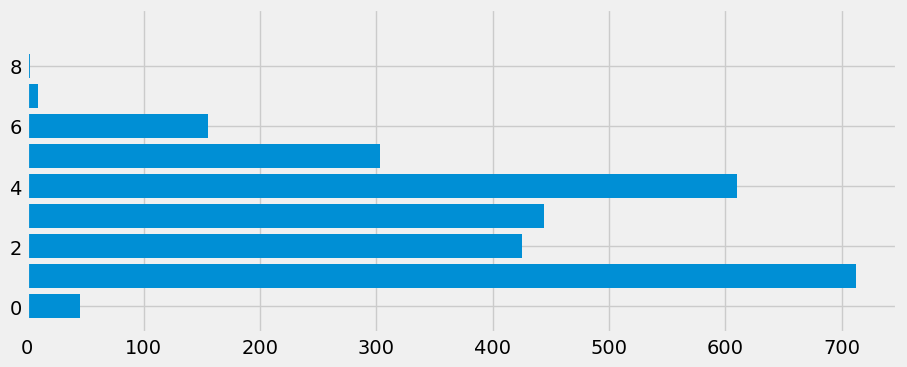

In [21]:
plt.figure(figsize=(10, 4))
ax=plt.barh(cleaned_df_condensed_trends["Book-Rating"].round(),
            cleaned_df_condensed_trends["Total-Num-Of-Ratings"])
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_25540\1859370092.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cleaned_df_condensed_trends.index,


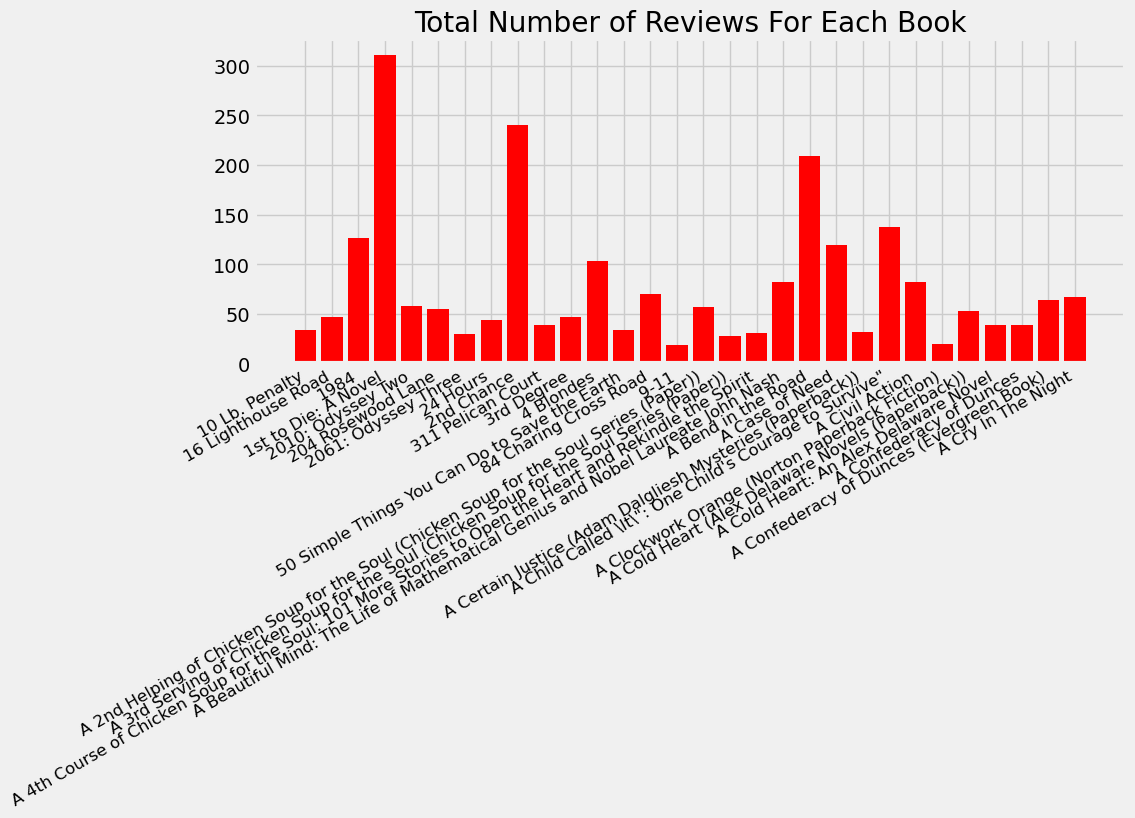

In [22]:
# A bar graph descibibg number of reviews for first 30 movies
plt.figure(figsize=(10, 4))
ax=plt.subplot()
ax.bar(cleaned_df_condensed_trends.head(30).index,
       cleaned_df_condensed_trends["Total-Num-Of-Ratings"].head(30), 
       color="r")
ax.set_xticklabels(cleaned_df_condensed_trends.index,
                   rotation=30,
                   fontsize="12",
                   horizontalalignment="right")
ax.set_title("Total Number of Reviews For Each Book")
plt.show()

In [23]:
# Calculate mean rating of all movies and check the popular high rating movies
cleaned_df_sorted_mean_rating = cleaned_df.copy().groupby("Book-Title")["Book-Rating"].mean().sort_values(ascending=False)
print("--------- Sorted by Mean On Average: ---------\n")
print("--------- TOP 50: ---------\n", cleaned_df_sorted_mean_rating.head(50), "\n\n--------- BOTTOM 50: ---------\n", cleaned_df_sorted_mean_rating.tail(50))

--------- Sorted by Mean On Average: ---------

--------- TOP 50: ---------
 Book-Title
Generation Golf. Eine Inspektion                                                                          9.000000
Novocento, Un Monologo                                                                                    9.000000
Io Non Ho Paura                                                                                           8.000000
Herr Lehmann.                                                                                             7.500000
L'Etranger (Collection Folio, 2)                                                                          6.777778
Griffin &amp; Sabine: An Extraordinary Correspondence                                                     6.000000
The Darwin Awards: Evolution in Action                                                                    5.653846
Harry Potter and the Sorcerer's Stone (Book 1)                                                            5

<Axes: xlabel='Book-Rating', ylabel='Count'>

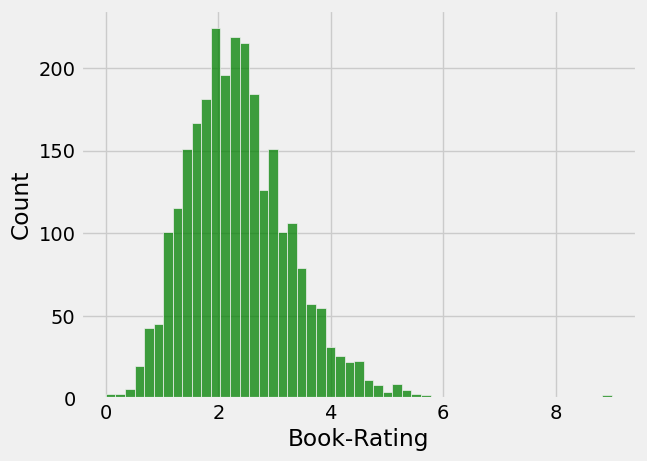

In [24]:
sns.histplot(pd.DataFrame(cleaned_df_sorted_mean_rating)["Book-Rating"], color="g")

In [25]:
report_basic_stats(cleaned_df, "Reduced")

Number of Unique Book Users in This Dataset (Reduced): 3000
Number of Unique Book Titles / ISBNs in This Dataset (Reduced): 3000
Number of Total Ratings in This Dataset (Reduced): 172071
Average Number of Book Ratings per User in This Dataset (Reduced): 57.357


In [26]:
X_train, X_test = train_test_split(cleaned_df, test_size=0.10, shuffle=True, random_state=2000)
X_val, X_test = train_test_split(X_test, test_size=0.50, shuffle=True, random_state=2000)

In [27]:
print("Shape of Training Set:", X_train.shape, "and Size of Training Set:", X_train.size)
print("Shape of Validation Set:", X_val.shape, "and Size of Validation Set:", X_val.size)
print("Shape of Test Set:", X_test.shape, "and Size of Testing Set:", X_test.size)

Shape of Training Set: (154863, 9) and Size of Training Set: 1393767
Shape of Validation Set: (8604, 9) and Size of Validation Set: 77436
Shape of Test Set: (8604, 9) and Size of Testing Set: 77436


In [28]:
X_train

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,New-ISBN,New-User-ID
158561,080410753X,The Kitchen God's Wife,Amy Tan,1992,Ivy Books,49635,7,396,2433
79007,0425191583,Imitation in Death (Eve Dallas Mysteries (Pape...,J. D. Robb,2004,Berkley Publishing Group,227520,10,1591,829
17766,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",134797,10,122,113
32001,0345337662,Interview with the Vampire,Anne Rice,1993,Ballantine Books,265313,0,639,228
133361,0373250207,Fishbowl (Red Dress Ink (Paperback)),Sarah Mlynowski,2002,Red Dress Ink,165308,8,1767,1711
...,...,...,...,...,...,...,...,...,...
165430,0446606189,Cat &amp; Mouse (Alex Cross Novels),James Patterson,1998,Warner Books,48057,0,2536,2684
69581,0441002935,The Lunatic Cafe (Anita Blake Vampire Hunter (...,Laurell K. Hamilton,2001,ACE Charter,176902,0,2084,709
62670,0971880107,Wild Animus,Rich Shapero,2004,Too Far,124079,6,3,605
168776,0345423402,A Kiss of Shadows (Meredith Gentry Novels (Pap...,LAURELL K. HAMILTON,2002,Ballantine Books,261998,9,1239,2836


In [29]:
df_ratings_train = np.zeros((n_users, n_books))
for r in X_train.itertuples():
    df_ratings_train[r[9] - 1, r[8] - 1] = r[7]
df_ratings_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
df_ratings_validation = np.zeros((n_users, n_books))
for r in X_val.itertuples():
    df_ratings_validation[r[9] - 1, r[8] - 1] = r[7]
df_ratings_validation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
df_ratings_test = np.zeros((n_users, n_books))
for r in X_test.itertuples():
    df_ratings_test[r[9] - 1, r[8] - 1] = r[7]
df_ratings_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
def print_sparsity_stats(df: pd.DataFrame, type: str):
    print("-------------- Sparsity Stats for {}: --------------".format(type))
    df_sparsity = float(len(df.nonzero()[0]))
    df_sparsity /= (df.shape[0] * df.shape[1])
    df_sparsity *= 100
    print('Sparsity: {:4.2f}%'.format(df_sparsity))

In [33]:
print_sparsity_stats(df_ratings_train, "Train")
print_sparsity_stats(df_ratings_validation, "Validation")
print_sparsity_stats(df_ratings_test, "Test")

-------------- Sparsity Stats for Train: --------------
Sparsity: 0.53%
-------------- Sparsity Stats for Validation: --------------
Sparsity: 0.03%
-------------- Sparsity Stats for Test: --------------
Sparsity: 0.03%


In [34]:
n_latent_fact = 1
user_input = Input(shape=[1], name="User")
user_embedding = Embedding(input_dim=n_users + 1, 
                           output_dim=n_latent_fact, 
                           name="User_Embedding")(user_input)
user_vec = Flatten(name="Flatten_Users")(user_embedding)
book_input = Input(shape=[1], name="Book")
book_embedding = Embedding(input_dim=n_books + 1, 
                           output_dim=n_latent_fact, 
                           name="Book_Embedding")(book_input)
book_vec = Flatten(name="Flatten_Movies")(book_embedding)
dot_product = dot([book_vec, user_vec], axes=1)

In [35]:
model = Model(inputs=[user_input, book_input], outputs=dot_product)
model.compile(loss="mse",
              optimizer=Adam(learning_rate=0.0001),
              metrics=["mean_absolute_error"])

In [36]:
book_rec_history = model.fit(x=(X_train["New-User-ID"], X_train["New-ISBN"]), 
                             y=X_train["Book-Rating"],
                             epochs=150,
                             validation_data=([X_val["New-User-ID"], X_val["New-ISBN"]], X_val["Book-Rating"]),
                             use_multiprocessing=True)

Epoch 1/150
4840/4840 [==============================] - 20s 4ms/step - loss: 19.9644 - mean_absolute_error: 2.4179 - val_loss: 20.2249 - val_mean_absolute_error: 2.4440
Epoch 2/150
4840/4840 [==============================] - 20s 4ms/step - loss: 19.9641 - mean_absolute_error: 2.4179 - val_loss: 20.2247 - val_mean_absolute_error: 2.4441
Epoch 3/150
4840/4840 [==============================] - 17s 4ms/step - loss: 19.9632 - mean_absolute_error: 2.4180 - val_loss: 20.2238 - val_mean_absolute_error: 2.4443
Epoch 4/150
4840/4840 [==============================] - 19s 4ms/step - loss: 19.9605 - mean_absolute_error: 2.4182 - val_loss: 20.2205 - val_mean_absolute_error: 2.4445
Epoch 5/150
4840/4840 [==============================] - 13s 3ms/step - loss: 19.9544 - mean_absolute_error: 2.4184 - val_loss: 20.2126 - val_mean_absolute_error: 2.4447
Epoch 6/150
4840/4840 [==============================] - 16s 3ms/step - loss: 19.9425 - mean_absolute_error: 2.4187 - val_loss: 20.1979 - val_mean_abs

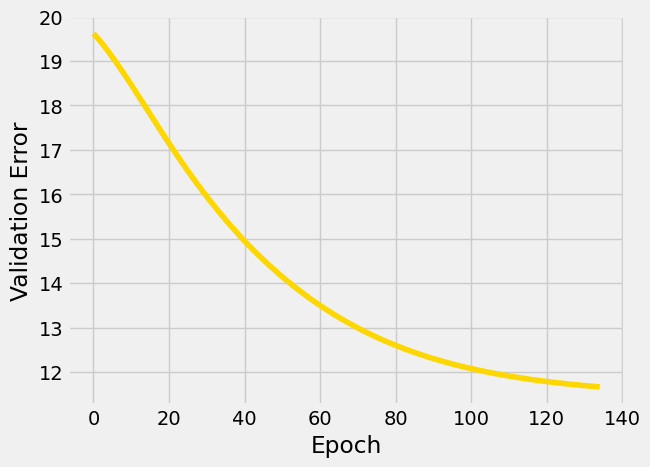

Minimum MSE: 11.662635803222656


In [37]:
pd.Series(book_rec_history.history["val_loss"][15:]).plot(logy=False, color="gold")
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
plt.show()

print("Minimum MSE:", min(book_rec_history.history["val_loss"]))

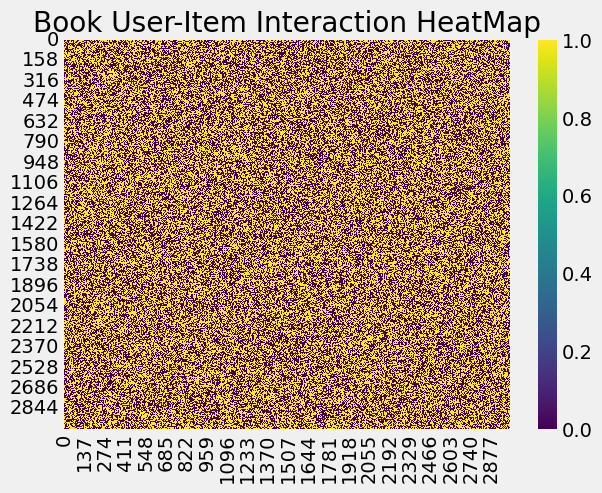

In [38]:
# NOTE: MAY REMOVE
book_users_interaction_matrix = np.random.randint(0, 2, size=[n_users, n_books])
sns.heatmap(book_users_interaction_matrix, cmap="viridis")
plt.title("Book User-Item Interaction HeatMap")
plt.show()

In [39]:
predicted_ratings = model.predict(x=(X_test["New-User-ID"], X_test["New-ISBN"])).flatten()

269/269 [==============================] - 0s 713us/step


269/269 [==============================] - 0s 802us/step - loss: 11.5146 - mean_absolute_error: 2.5807
Train Result:
Lost Score (When Compared to Test Set): 11.5146
_______________________________________________
Average Precision Score (When Compared to Test Set): 0.3728
_______________________________________________
Accuracy Score (When Compared to Test Set): 0.2581 (as a percentage: 25.81%)
_______________________________________________
ROC AUC Score: 73.20%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.971005    0.182320  0.738726     0.576663      0.912523
recall        0.739895    0.724138  0.738726     0.732016      0.738726
f1-score      0.839840    0.291299  0.738726     0.565570      0.799165
support    7966.000000  638.000000  0.738726  8604.000000   8604.000000
_______________________________________________
Confusion Matrix: 
 [[5894 2072]
 [ 176  462]]



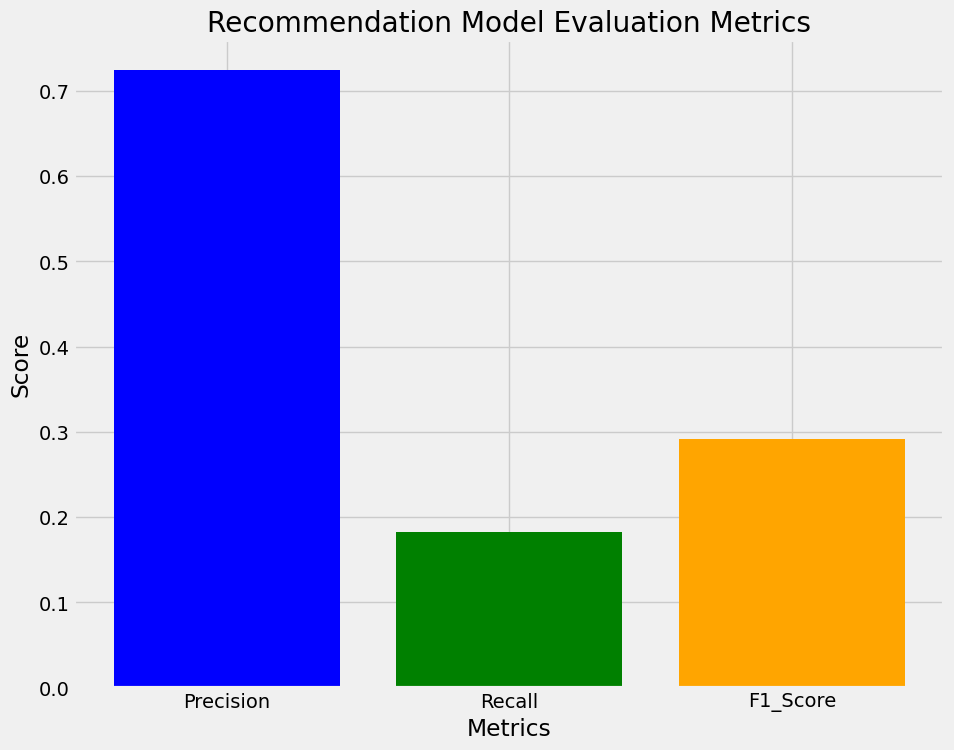

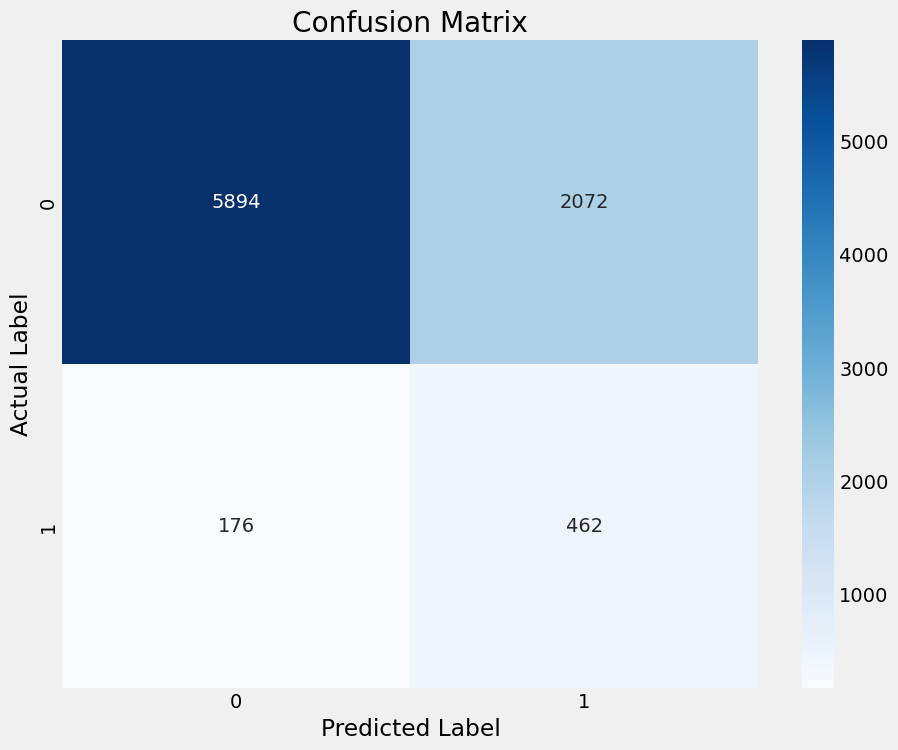

In [40]:
book_rec_history_model_loss, book_rec_history_model_accuracy = model.evaluate(x=(X_test["New-User-ID"], X_test["New-ISBN"]), y=X_test["Book-Rating"])
book_rec_history_model_accuracy /= 10

# Threshold the predicted ratings to binary recommendations (e.g., using a threshold of >= 5 for recommending book)
threshold = 5
predicted_labels_bin_classify = (predicted_ratings.copy() >= threshold).astype(int)
actual_labels_bin_classify = (X_test["Book-Rating"].copy() >= threshold).astype(int)

actual_ratings_str = predicted_labels_bin_classify.copy().astype(int)
predicted_ratings_str = actual_labels_bin_classify.copy().astype(int)
clf_report = pd.DataFrame(classification_report(y_true=actual_ratings_str, y_pred=predicted_ratings_str, output_dict=True, zero_division=0))

y_test_book_rating = predicted_labels_bin_classify
y_pred_book_rating = actual_labels_bin_classify

print("Train Result:\n================================================")
print(f"Lost Score (When Compared to Test Set): {book_rec_history_model_loss:.4f}")
print("_______________________________________________")
print(f"Average Precision Score (When Compared to Test Set): {average_precision_score(y_true=actual_labels_bin_classify, y_score=predicted_labels_bin_classify):.4f}")
print("_______________________________________________")
print(f"Accuracy Score (When Compared to Test Set): {book_rec_history_model_accuracy:.4f}", f"(as a percentage: {book_rec_history_model_accuracy * 100:.2f}%)")
print("_______________________________________________")
print(f"ROC AUC Score: {roc_auc_score(y_test_book_rating, y_pred_book_rating) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test_book_rating, y_pred_book_rating)}\n")

# Calculate Precision, Recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true=actual_labels_bin_classify, y_pred=predicted_labels_bin_classify, average='binary')
model_performance_metrics: [str] = ["Precision", "Recall", "F1_Score"]
model_performance_metrics_values: [float] = [precision, recall, f1_score]

plt.figure(figsize=(10, 8))
plt.bar(model_performance_metrics, model_performance_metrics_values, color=['blue', 'green', 'orange'])
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Recommendation Model Evaluation Metrics')
plt.show()

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test_book_rating, y_pred_book_rating)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()